In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from plot_metric.functions import BinaryClassification

from numpy import mean
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Data Visualization

## Customer Data

In [2]:
customer_data = pd.read_csv(r".\data\customer_data.csv")
customer_data.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [3]:
customer_data.shape

(1125, 13)

In [4]:
for col in customer_data.columns:
    print(col)
    print(customer_data[col].value_counts())
    print()

label
0    900
1    225
Name: label, dtype: int64

id
58998781    1
58997719    1
59005841    1
59001486    1
59003535    1
           ..
58991921    1
54990128    1
54986029    1
54986897    1
58982401    1
Name: id, Length: 1125, dtype: int64

fea_1
7    476
4    377
5    261
1      7
6      2
2      2
Name: fea_1, dtype: int64

fea_2
1241.0    37
1214.0    27
1305.5    23
1287.5    21
1223.0    21
          ..
1344.5     1
1194.5     1
1455.5     1
1404.5     1
1188.5     1
Name: fea_2, Length: 158, dtype: int64

fea_3
3    684
1    309
2    132
Name: fea_3, dtype: int64

fea_4
35000.0     34
50000.0     25
150000.0    19
90000.0     19
110000.0    18
            ..
198000.0     1
243000.0     1
488000.0     1
166000.0     1
264000.0     1
Name: fea_4, Length: 229, dtype: int64

fea_5
2    1045
1      80
Name: fea_5, dtype: int64

fea_6
11    465
8     375
15    259
12     11
4       4
5       3
16      2
9       2
6       2
3       2
Name: fea_6, dtype: int64

fea_7
 5     689
 9  

The customer data is split into two groups;
- numerical features: ["fea_2", "fea_4", "fea_8", "fea_10", "fea_11"]
- categorical features: ["fea_1", "fea_3", "fea_5", "fea_6", "fea_7", "fea_9"]

### Function to display proportion of missing values

In [5]:
def print_proportion_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=True)
    percent = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False)
    percent = round(percent,2)
    missing_proportion = pd.concat([total, percent], keys=['Total', 'Missing Proportion'], axis=1)
    print(missing_proportion)

    return None

In [6]:
print_proportion_missing_data(customer_data)

        Total  Missing Proportion
label       0                0.00
id          0                0.00
fea_1       0                0.00
fea_3       0                0.00
fea_4       0                0.00
fea_5       0                0.00
fea_6       0                0.00
fea_7       0                0.00
fea_8       0                0.00
fea_9       0                0.00
fea_10      0                0.00
fea_11      0                0.00
fea_2     149               13.24


#### Display distribution of the lables

In [7]:
customer_data['label'].value_counts(normalize=True)

0    0.8
1    0.2
Name: label, dtype: float64

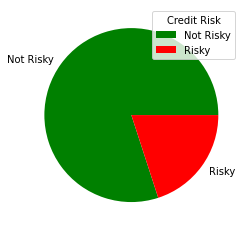

In [8]:
plt.pie(customer_data['label'].value_counts(), 
        labels=['Not Risky', 'Risky'], 
        colors=['g','r'])
plt.legend(title='Credit Risk')

The distribution of the labels show class imabalance in the customer dataset as 80% of the dataset has a label of 1. This implies that 20% of the customers were credit risky to the specific banks.

This class imbalancw could lead to poor predictive performance and classification of the minority class, as the machine learning classifier will tend to be more biased towards the majority class.

## Payment Data

In [9]:
payment_data = pd.read_csv(r".\data\payment_data.csv")
payment_data.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


#### Feature description of Payment Data

- id: customer id 
- OVDt1: number of times overdue type 1
- OVDt2: number of times overdue type 2 
- OVDt3: number of times overdue type 3
- OVDsum: total overdue days 
- paynormal: number of times normal payment
- prodcode: credit product code 
- prodlimit: credit limit of product
- updatedate: account update date 
- newbalance: current balance of product
- highestbalance: highest balance in history 
- reportdate: date of recent payment

We will use the following attributes from the payment data for the analysis
- id: customer id 
- OVDsum: total overdue days 
- paynormal: number of times normal payment
- prodlimit: credit limit of product
- newbalance: current balance of product
- highestbalance: highest balance in history 

In [10]:
payment_data = payment_data[['id', 'OVD_sum', 'pay_normal', 'prod_limit', 'new_balance', 'highest_balance']]
payment_data.head()

,id,OVD_sum,pay_normal,prod_limit,new_balance,highest_balance
0,58987402,0,1,16500.0,0.0,NaN
1,58995151,0,1,NaN,588720.0,491100.0
2,58997200,0,2,NaN,840000.0,700500.0
3,54988608,0,3,37400.0,8425.2,7520.0
4,54987763,0,2,NaN,15147.6,NaN


In [11]:
payment_data.shape

(8250, 6)

In [12]:
print_proportion_missing_data(payment_data)

                 Total  Missing Proportion
id                   0                0.00
OVD_sum              0                0.00
pay_normal           0                0.00
new_balance          0                0.00
highest_balance    409                4.96
prod_limit        6118               74.16


In [13]:
for col in payment_data.columns:
    print(col)
    print(payment_data[col].value_counts())
    print()

id
58988212    55
54990497    48
58998646    45
58991343    39
58987276    39
            ..
58986809     1
59004100     1
59004658     1
59003724     1
54984717     1
Name: id, Length: 1125, dtype: int64

OVD_sum
0       7330
1         76
30        52
15        19
2         15
        ... 
420        1
452        1
524        1
6671       1
4006       1
Name: OVD_sum, Length: 393, dtype: int64

pay_normal
1     910
36    651
2     419
3     345
4     315
9     299
6     294
35    286
0     285
10    284
8     283
5     283
7     279
12    262
11    254
13    187
15    183
14    174
34    168
16    147
19    147
20    136
21    127
18    125
17    124
25    121
28    121
33    119
31    117
22    110
24    109
32    105
26    103
27    103
23    101
29     88
30     86
Name: pay_normal, dtype: int64

prod_limit
55000.0     103
11000.0      86
33000.0      51
27500.0      47
22000.0      46
           ... 
267300.0      1
12650.0       1
355300.0      1
145200.0      1
39601.1       1
N

# Data Preparation

### Customer Data
For the customer data, we will fill missing fea_2 values with the mean of that feature.

In [14]:
# Fill missing "fea_2" values with the mean
customer_data['fea_2'].fillna(customer_data['fea_2'].mean(), inplace=True)

# display proportion of missing values
print_proportion_missing_data(customer_data)

        Total  Missing Proportion
label       0                 0.0
id          0                 0.0
fea_1       0                 0.0
fea_2       0                 0.0
fea_3       0                 0.0
fea_4       0                 0.0
fea_5       0                 0.0
fea_6       0                 0.0
fea_7       0                 0.0
fea_8       0                 0.0
fea_9       0                 0.0
fea_10      0                 0.0
fea_11      0                 0.0


### Payment Data
For the payment data, we will do the following
- drop "prod_limit' because 74% of the records are missing
- fill missing values of the "highest_balance" with the mean

In [15]:
payment_data.describe()

,id,OVD_sum,pay_normal,prod_limit,new_balance,highest_balance
count,8.250000e+03,8250.000000,8250.000000,2132.000000,8.250000e+03,7.841000e+03
mean,5.782173e+07,187.681697,14.526667,85789.702205,1.054042e+05,2.192027e+05
std,1.822724e+06,1804.232570,12.053627,74345.828184,1.887704e+06,2.814536e+06
min,5.498235e+07,0.000000,0.000000,1.100000,-4.030320e+04,5.010000e+02
25%,5.499050e+07,0.000000,4.000000,37400.000000,0.000000e+00,2.345300e+04
50%,5.898905e+07,0.000000,11.000000,68200.000000,0.000000e+00,4.404700e+04
75%,5.899655e+07,0.000000,25.000000,112200.000000,2.494800e+04,1.005000e+05
max,5.900624e+07,31500.000000,36.000000,660000.000000,1.632120e+08,1.800005e+08


In [16]:
# drop 'prod_limit', 'report_date', 'update_date' 
payment_data.drop(['prod_limit'], axis=1, inplace=True)

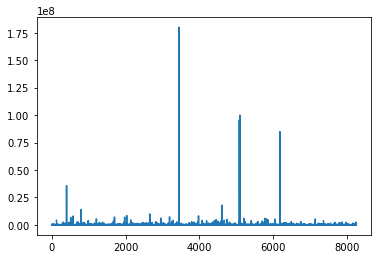

In [17]:
# plot the values of the highest_blance attribute
payment_data['highest_balance'].plot()

In [18]:
# Fill missing "highest_balance" values with the mean
payment_data['highest_balance'].fillna(payment_data['highest_balance'].mean(), inplace=True)

In [19]:
# display proportion of missing values
print_proportion_missing_data(payment_data)

                 Total  Missing Proportion
id                   0                 0.0
OVD_sum              0                 0.0
pay_normal           0                 0.0
new_balance          0                 0.0
highest_balance      0                 0.0


In [20]:
# Merge both dataset
credit_data = customer_data.merge(payment_data, how='inner', on='id')
credit_data.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_sum,pay_normal,new_balance,highest_balance
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,9,6657.6,18934.0
1,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,18,153792.0,149387.0
2,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,0,1,0.0,150500.0
3,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974,11906,6,0.0,46371.0
4,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840,0,4,15120.0,21500.0


In [21]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8250 entries, 0 to 8249
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            8250 non-null   int64  
 1   id               8250 non-null   int64  
 2   fea_1            8250 non-null   int64  
 3   fea_2            8250 non-null   float64
 4   fea_3            8250 non-null   int64  
 5   fea_4            8250 non-null   float64
 6   fea_5            8250 non-null   int64  
 7   fea_6            8250 non-null   int64  
 8   fea_7            8250 non-null   int64  
 9   fea_8            8250 non-null   int64  
 10  fea_9            8250 non-null   int64  
 11  fea_10           8250 non-null   int64  
 12  fea_11           8250 non-null   float64
 13  OVD_sum          8250 non-null   int64  
 14  pay_normal       8250 non-null   int64  
 15  new_balance      8250 non-null   float64
 16  highest_balance  8250 non-null   float64
dtypes: float64(5),

In [22]:
# check for class imbalance after merging datasets
round(credit_data['label'].value_counts(normalize=True)*100,0)

0    83.0
1    17.0
Name: label, dtype: float64

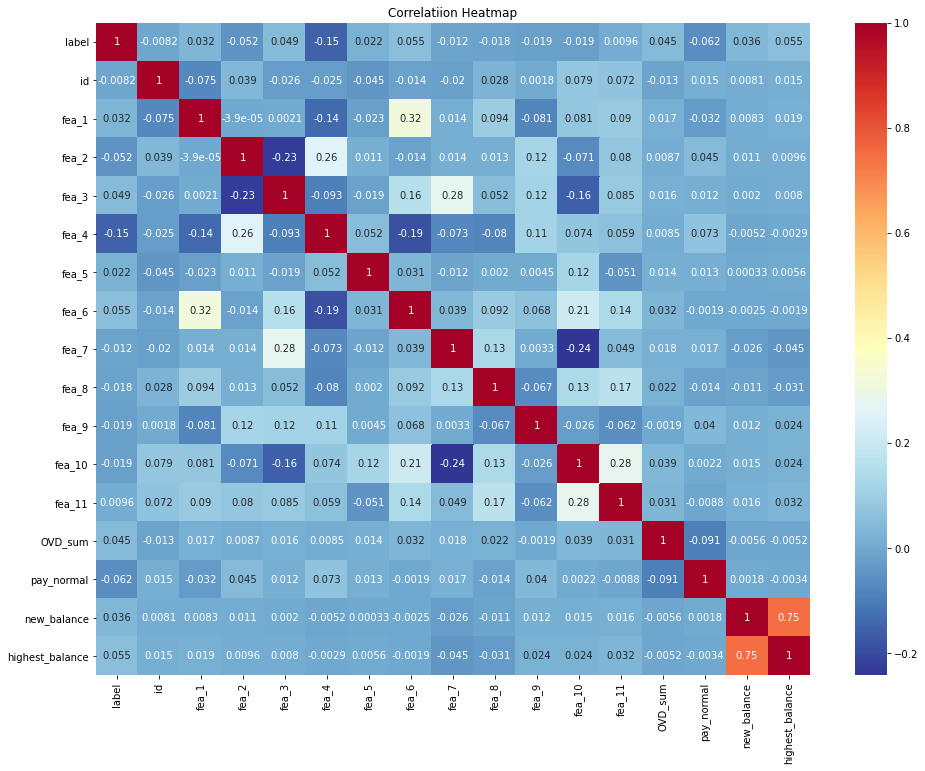

In [23]:
plt.figure(figsize=(16,12))
sns.heatmap(credit_data.corr(),
            cmap=plt.cm.RdYlBu_r,
            annot=True)
plt.title('Correlatiion Heatmap');

The heatmap/confusion matrix doesn't show strong correlation between the features and the label. This could be as a result of the class imbalance issue in the dataset.

Therefore, before proceeding with model development, the class imbalance issue will first be dealt with.

In [24]:
all_features = credit_data.drop(['id','label'], axis=1).columns
cat_cols = ["fea_1", "fea_3", "fea_5", "fea_6", "fea_7", "fea_9"] 
num_cols = ['fea_2', 'fea_4','fea_8','fea_10','fea_11','OVD_sum','pay_normal','new_balance','highest_balance']

### Data Modelling

#### Scale the numerical features

In [25]:
def scale_numerical_features(data, num_cols):
    # copy of datasets
    data_sca = data.copy()

    # apply standardization on numerical features
    for col in num_cols:

        # fit on training data column
        scale = StandardScaler().fit(data_sca[[col]])

        # transform the training data column
        data_sca[col] = scale.transform(data_sca[[col]])
        
    return data_sca

In [26]:
# scaling the dataset
credit_data_scaled = scale_numerical_features(credit_data, num_cols)

In [27]:
credit_data_scaled.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_sum,pay_normal,new_balance,highest_balance
0,1,54982665,5,-0.829829,3,-0.570237,2,15,5,0.715645,5,-0.223178,0.752965,-0.104029,-0.458534,-0.052314,-0.072992
1,1,54982665,5,-0.829829,3,-0.570237,2,15,5,0.715645,5,-0.223178,0.752965,-0.104029,0.288174,0.025635,-0.025446
2,1,54982665,5,-0.829829,3,-0.570237,2,15,5,0.715645,5,-0.223178,0.752965,-0.104029,-1.122275,-0.055841,-0.025040
3,1,54982665,5,-0.829829,3,-0.570237,2,15,5,0.715645,5,-0.223178,0.752965,6.495298,-0.707437,-0.055841,-0.062992
4,0,59004779,4,-0.182441,1,-0.237366,2,8,-1,-0.002098,3,0.917153,0.443523,-0.104029,-0.873372,-0.047830,-0.072057


In [28]:
# Split your data into an X matrix and a target variable y
X = credit_data_scaled.drop(['id', 'label'], axis=1)
y = credit_data_scaled.label

print("Shape of features: {}".format(X.shape))
print("Shape of target: {}".format(y.shape))

# Split data into training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.20, random_state=42)

print("Size of training dataset: {} rows".format(X_train.shape[0]))
print("Size of validation dataset: {} rows".format(X_test.shape[0]))

Shape of features: (8250, 15)
Shape of target: (8250,)
Size of training dataset: 6600 rows
Size of validation dataset: 1650 rows


In [29]:
round(y_test.value_counts(normalize=True)*100,0)

0    84.0
1    16.0
Name: label, dtype: float64

In [30]:
round(y_train.value_counts(normalize=True)*100,0)

0    83.0
1    17.0
Name: label, dtype: float64

The split process results in equal proportion of the labels in the train and test sets.

### Balance the dataset

To resolve this, we will up-sample the minority class, "label == 1", by randomly duplicating observations from that class, with replacement. These will subsequently be added back to the training set. This technique can only be applied to the training dataset, and never on the test data. The basic idea behind this technique is to influence or improve the fit of the model.

We will apply this technique when we split the data into training and test data.

In [31]:
# copy the split training features
training_set = X_train.copy()

# add the training target to the training features
training_set['label'] = y_train
training_set.head()

,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11,OVD_sum,pay_normal,new_balance,highest_balance,label
7149,5,-0.706517,3,-0.135656,2,15,9,0.954892,4,-0.769272,0.384758,-0.104029,-1.122275,-0.055841,-0.025040,0
833,4,0.711572,1,-0.006206,2,8,9,0.635895,3,-0.769817,0.486397,-0.104029,1.449721,-0.055841,-0.070457,0
2118,7,-1.970465,3,-0.403802,2,11,5,-0.959087,3,-0.769703,-1.245386,-0.104029,-0.209631,0.002978,-0.043710,1
3921,7,-1.292249,3,-0.773659,2,11,5,-0.879338,5,-0.769404,-1.245386,-0.104029,-0.292599,-0.055841,-0.069724,1
549,4,0.865712,3,0.086258,2,8,2,0.795394,5,-0.769434,-1.245386,-0.090726,1.698623,-0.055794,-0.018568,0


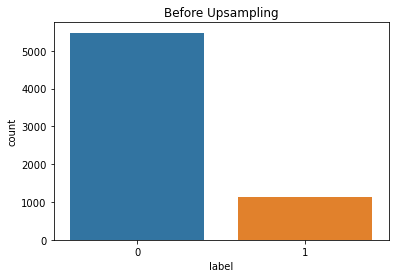

In [32]:
sns.countplot(training_set.label)
plt.title("Before Upsampling");

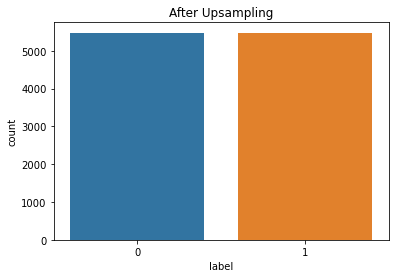

In [33]:
# PERFORM UP-SAMPLING OF THE TRAINING SETS

# select the subset of data with the most class distribution
majority = training_set[training_set.label==0]

# select the subset of data with the least class distribution
minority = training_set[training_set.label==1]

minority_upsampled = resample(minority, 
                              replace=True,                   # sample with replacement
                              n_samples=majority.shape[0],    # to match majority class
                              random_state=123)               # reproducible results
up_sampled = {
    "No" : majority,
    "Yes" : minority_upsampled
}

balanced_credit_data = pd.concat([up_sampled["No"], up_sampled["Yes"]])
sns.countplot(balanced_credit_data.label)
plt.title("After Upsampling");

The training data now has equal number of risky and non-risky customers.

### Building the Models

In [34]:
X_train_bal = balanced_credit_data.drop('label', axis=1)
y_train_bal = balanced_credit_data['label']


data = [X_train_bal, y_train_bal, X_test, y_test]

In [35]:
def fit_model(alg, data, n_splits=None):
    """
        Fits a model to the training data, performs prediction and cross validation and computes
        the feature importance.
        
        args:
            alg - the algorithm to fit to the training data
            data - a list of the training and test data
            n_splits - the number of groups to split the training data into during cross validation
            
        returns:
            model_accuracy: a score of the model's accuracy
    """
    
    # Train the model using the training sets
    model = alg.fit(data[0], data[1])

    # Model Prediction on train data
    predicted_label = model.predict(data[2])
    
    # Use predict_proba to predict the probability estimates of the positive class
    predicted_label_prob = model.predict_proba(data[2])[:,1]
    
    # Perform Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
    ROC_scores = cross_val_score(model, data[0], data[1], scoring='roc_auc', cv=cv, n_jobs=-1)
    mean_ROC_score = mean(ROC_scores)

    # summary of model performance
    print('CROSS VALIDATION MEAN ROC AUC: %.2f' % mean_ROC_score)
    
    # Plot the Classification ROC curve
    plot_roc_curve(data[3],predicted_label_prob)
    
    return model

In [36]:
def plot_roc_curve(true, predicted):
    
    # Visualisation with plot_metric
    bc = BinaryClassification(true, predicted, labels=["Non-Risky", "Risky"])
    
    # display the classification report
    bc.print_report()

    # Figures
    plt.figure(figsize=(12,5))
    
    # Plot the Classification ROC curve
    plt.subplot(1, 2, 1)
    bc.plot_roc_curve()
    
    # Plot the normalized confusion matrix
    plt.subplot(1, 2, 2)
    bc.plot_confusion_matrix(normalize=True, cmap="Reds")
    plt.show()

## Logistic Regression

C:\Users\kosit\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CROSS VALIDATION MEAN ROC AUC: 0.67
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

   Non-Risky       0.89      0.57      0.69      1384
       Risky       0.22      0.65      0.33       266

    accuracy                           0.58      1650
   macro avg       0.56      0.61      0.51      1650
weighted avg       0.79      0.58      0.64      1650



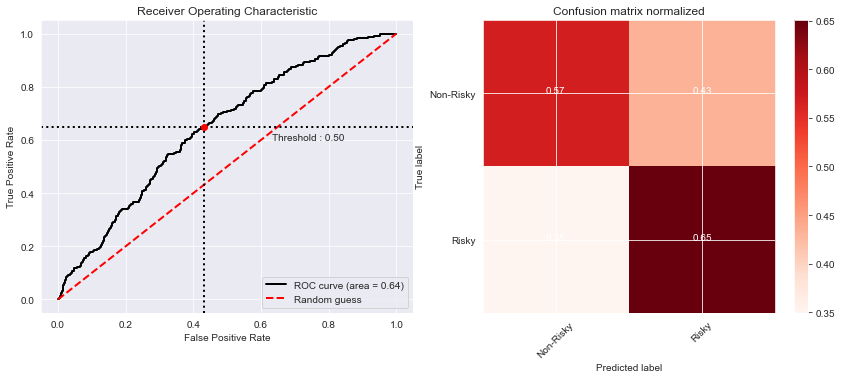

Wall time: 4.31 s


LogisticRegression()

In [37]:
%%time
# Instantiate the Logistic Regression
logreg_model = LogisticRegression()

# Fit the model and print performance results
fit_model(logreg_model, data, 10);

## Support Vector Machine

CROSS VALIDATION MEAN ROC AUC: 0.74
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

   Non-Risky       0.90      0.67      0.77      1384
       Risky       0.27      0.63      0.38       266

    accuracy                           0.67      1650
   macro avg       0.59      0.65      0.58      1650
weighted avg       0.80      0.67      0.71      1650



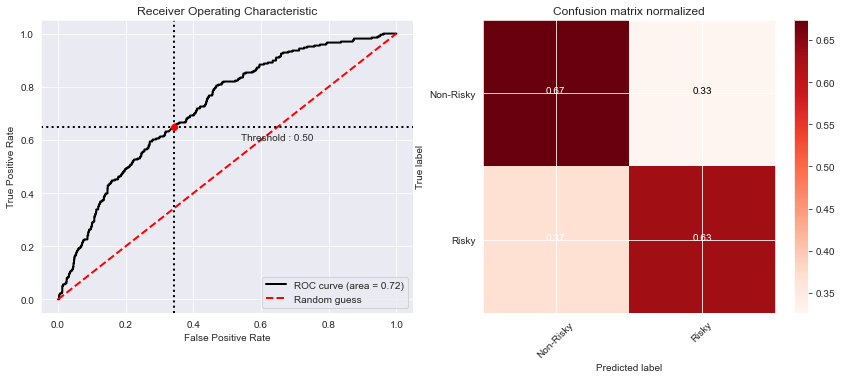

Wall time: 4min 1s


SVC(probability=True)

In [38]:
%%time
clf = svm.SVC(probability=True)
fit_model(clf, data, 10)

#### k-Nearest Neighbor (kNN) Classifier

CROSS VALIDATION MEAN ROC AUC: 0.98
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

   Non-Risky       0.97      0.90      0.94      1384
       Risky       0.64      0.86      0.73       266

    accuracy                           0.90      1650
   macro avg       0.80      0.88      0.83      1650
weighted avg       0.92      0.90      0.90      1650



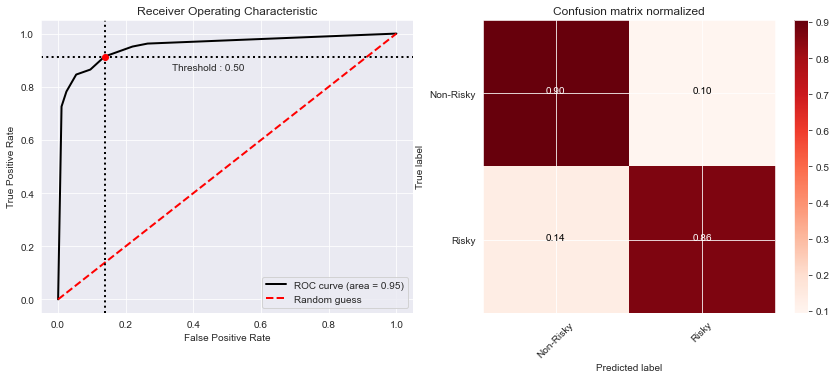

KNeighborsClassifier(n_neighbors=8)

In [50]:
# Seelct random number of neighbours
k = 8
neigh = KNeighborsClassifier(n_neighbors = k)

# Fit the model and print performance results
fit_model(neigh, data, 10)

With a random number of nearest neighbour of 8, the model achieved an AUC of 0.95. We will choose a range of values for k and select the value with the least error and most accuracy values.

### Optimizing the k-nearest neighbor model
#### Error

Minimum error:- 0.03151515151515152 at K = 0


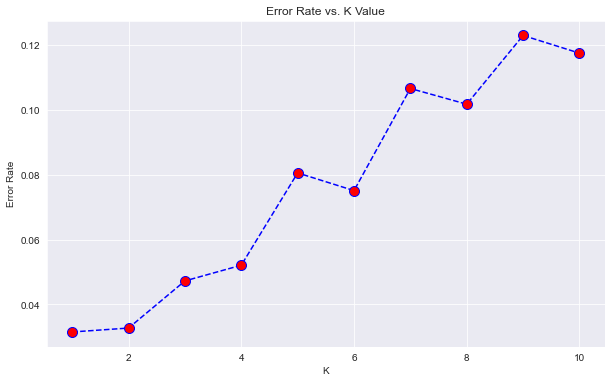

In [47]:
error_rate = []
for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(data[0], data[1])
    pred_k = knn.predict(data[2])
    error_rate.append(np.mean(pred_k != data[3]))

plt.figure(figsize=(10,6))
plt.plot(range(1,11),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

#### Accuracy

Maximum accuracy:- 0.9684848484848485 at K = 0


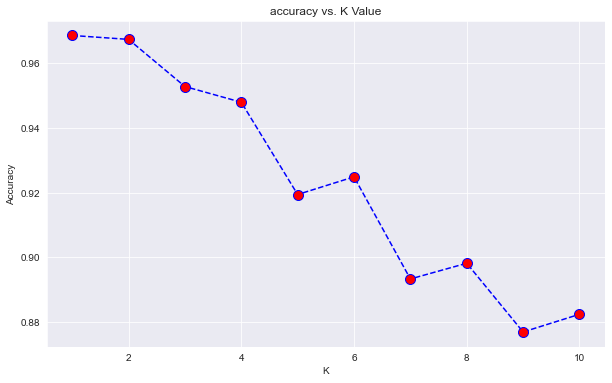

In [52]:
acc = []
for k in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(data[0], data[1])
    yhat = neigh.predict(data[2])
    acc.append(metrics.accuracy_score(data[3], yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,11),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

The plots show that a k value of 1 gives the least error and most accuacy values. Therefore we will select k=1 for the KNN model.

CROSS VALIDATION MEAN ROC AUC: 0.99
                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

   Non-Risky       0.98      0.98      0.98      1384
       Risky       0.90      0.90      0.90       266

    accuracy                           0.97      1650
   macro avg       0.94      0.94      0.94      1650
weighted avg       0.97      0.97      0.97      1650



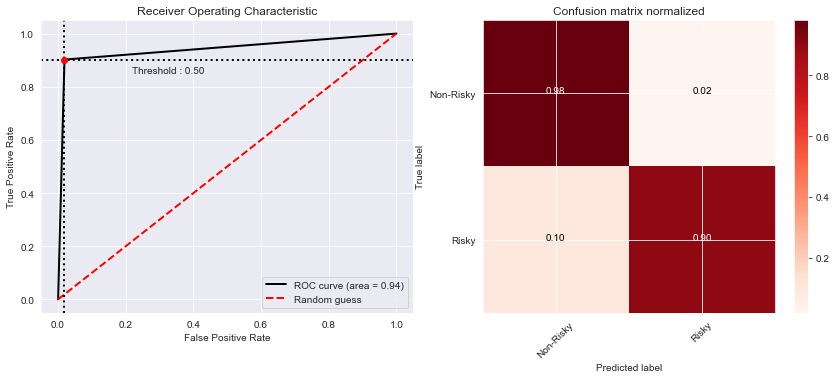

KNeighborsClassifier(n_neighbors=1)

In [49]:
k = 1
neigh = KNeighborsClassifier(n_neighbors = k)

# Fit the model and print performance results
fit_model(neigh, data, 10)